In [33]:
# !git clone https://github.com/konanna/DNN.git
# !cd DNN && git checkout dev_Anna

In [34]:
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import torch
import sys
import json
import numpy as np
import torch.nn.functional as F

In [35]:
src_path = 'DNN'
if src_path not in sys.path:
    sys.path.append(src_path)

In [36]:
from src.utils import set_det_pos, get_detector_imgs, visualize_n_samples, mask_visualization
from src.DNN import Fourier_DNN, Trainer, new_Fourier_DNN
# from src.real_space_DNN import real_space_DNN, real_space_DNN_conv

In [58]:
# Загрузка датасета
BATCH_SIZE = 50
IMG_SIZE = 32*5
N_pixels = 200
PADDING = (N_pixels - IMG_SIZE) // 2

transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Resize((IMG_SIZE,IMG_SIZE)),
                                transforms.Pad(PADDING)])

"""
MNIST
"""

# transform = transforms.Compose([transforms.ToTensor(), 
#                                 transforms.Resize((IMG_SIZE,IMG_SIZE)),
#                                 transforms.Pad(PADDING)])
# train_dataset = torchvision.datasets.MNIST("./data", train=True, transform=transform, download=True)
# val_dataset = torchvision.datasets.MNIST("./data", train=False, transform=transform, download=True)
# train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
# val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)

"""
Fashion_MNIST
"""
# transform = transforms.Compose([transforms.ToTensor(), 
#                                 transforms.Resize((IMG_SIZE,IMG_SIZE)),
#                                 transforms.Pad(PADDING)])
# train_dataset = torchvision.datasets.FashionMNIST("./data", train=True, transform=transform, download=True)
# val_dataset = torchvision.datasets.FashionMNIST("./data", train=False, transform=transform, download=True)
# train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
# val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)

"""
CIFAR10
"""
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Grayscale(),
                                transforms.Resize((IMG_SIZE,IMG_SIZE)),
                                transforms.Pad(PADDING)])
train_dataset = torchvision.datasets.CIFAR10("./data", train=True, transform=transform, download=True)
val_dataset = torchvision.datasets.CIFAR10("./data", train=False, transform=transform, download=True)
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [50]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


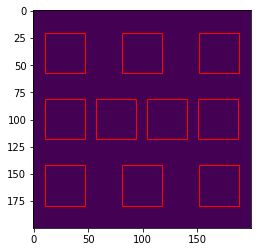

In [59]:
# det_size = 40
# edge_x = 10
# edge_y = 20

edge_x = N_pixels // 20
edge_y = edge_x * 2
det_size = (N_pixels - 5 * edge_x)//4

labels_image_tensors, detector_pos = get_detector_imgs(det_size = det_size, 
                                                       edge_x = edge_x , 
                                                       edge_y = edge_y, 
                                                       N_pixels = N_pixels)
labels_image_tensors = labels_image_tensors.to(device)

In [52]:
def custom_loss(imgs, labels):
    full_int = imgs.sum(dim=(1,2))
    loss = 1 - (imgs*labels_image_tensors[labels]).sum(dim=(1,2))/full_int
    return loss.mean()

def custom_loss_MSE(imgs, labels):
    full_int_img = imgs.sum(dim=(1,2))[:,None, None]
    full_int_label = labels_image_tensors[labels].sum(dim = (1,2))[:,None, None]
    loss = ((imgs/full_int_img - labels_image_tensors[labels]/full_int_label)**2).sum(dim = (1,2))
    return loss.mean()
  
crossEntropy = torch.nn.CrossEntropyLoss().to(device)
def custom_loss_CrossEntropy(imgs, labels, multiplier = 10):
    full_int_img = imgs.sum(dim=(1,2))[:,None, None]
    detector_parts = (imgs[:,None, :, :]*(labels_image_tensors[None, :, :, :])).sum(dim = (2,3))
    detector_parts = detector_parts/(detector_parts.max(dim = 1).values[:,None])* multiplier
    return crossEntropy(detector_parts, labels)

def custom_loss_CrossEntropy_MSE(imgs, labels, multiplier = 10):
    full_int_img = imgs.sum(dim=(1,2))[:,None, None]
    detector_parts = (imgs[:,None, :, :]*(labels_image_tensors[None, :, :, :])).sum(dim = (2,3))
    detector_parts = detector_parts/(detector_parts.max(dim = 1).values[:,None]) * multiplier 
    detector_intensity = (1 - detector_parts.sum(dim = 1)/full_int_img).mean()
    return 0.2* crossEntropy(detector_parts, labels) + 0.8 * detector_intensity

def custom_loss_sum(imgs, labels, multiplier = 10):
  return 500 * custom_loss_MSE(imgs, labels) + 1 * custom_loss_CrossEntropy(imgs, labels, multiplier = 10)

In [60]:
f = 100e-3
pixel_size = 2e-6 / 3 #m
wl = 532e-9 #m 
distance_between_layers = 3e-3
N_layers = 5

n_esun = 1.46
n_formlabs = 1.56
n_alc = 1.36

dn = n_esun-n_alc + 0.00001j
# dn = None
include_amplitude_modulation = True
model = new_Fourier_DNN(num_layers = N_layers, 
                        wl = wl, 
                        N_pixels = N_pixels, 
                        pixel_size = pixel_size,
                        N_neurons = 40,
                        distance = distance_between_layers, 
                        lens_focus = f,
                        include_amplitude_modulation = include_amplitude_modulation,
                        dn = dn).to(device)
#criterion = torch.nn.MSELoss(reduction='sum').to(device)
#criterion = torch.nn.CrossEntropyLoss().to(device)
#criterion = custom_loss
criterion = custom_loss_sum
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

In [42]:
# model = real_space_DNN(5, wl, N_pixels, pixel_size, N_pixels//10, pixel_size*10, distance_between_layers, distance_between_layers).to(device)
# model = real_space_DNN_conv(5, wl, N_pixels, pixel_size, N_pixels//10, pixel_size*10, distance_between_layers, distance_between_layers, device).to(device)


In [61]:
trainer = Trainer(model, detector_pos, 0, device)

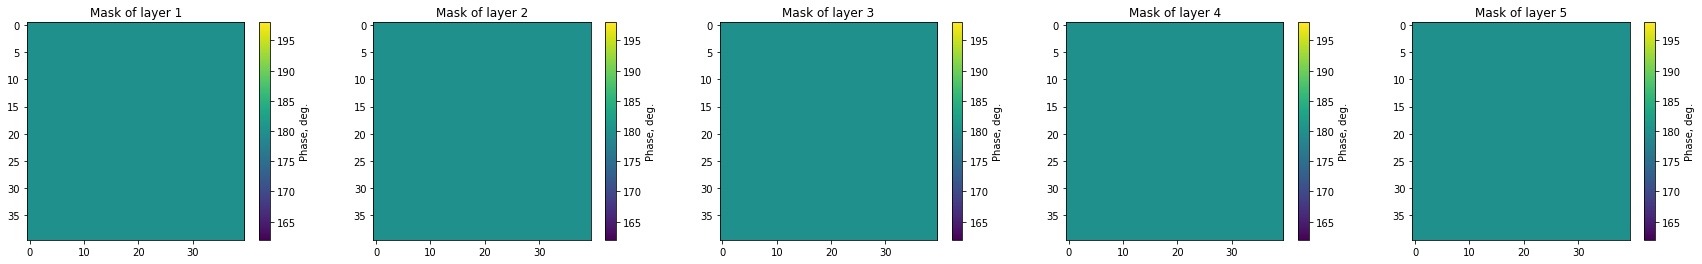

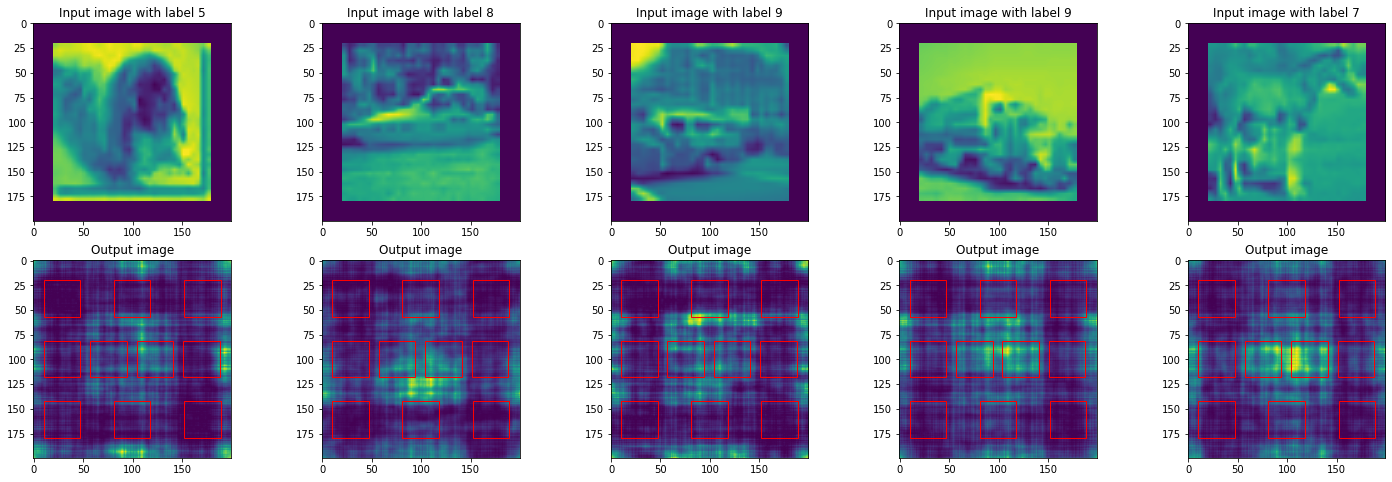

In [62]:
mask_visualization(model)
visualize_n_samples(model, val_dataset, n = 5, padding = 0, detector_pos = detector_pos)

In [64]:
# res = trainer.train(criterion, optimizer, train_dataloader, val_dataloader, epochs = 5, discrete_thickness = 1e-9)
res = trainer.train(criterion, optimizer, train_dataloader, val_dataloader, epochs = 10)

100%|██████████| 200/200 [00:21<00:00,  9.29it/s]



Epoch=1 train loss=2.357, test loss=2.356
train acc=0.28, test acc=0.2783
-----------------------


100%|██████████| 200/200 [00:21<00:00,  9.35it/s]



Epoch=2 train loss=2.34, test loss=2.34
train acc=0.2898, test acc=0.3002
-----------------------


100%|██████████| 200/200 [00:21<00:00,  9.30it/s]



Epoch=3 train loss=2.326, test loss=2.333
train acc=0.2998, test acc=0.2948
-----------------------


100%|██████████| 200/200 [00:22<00:00,  9.08it/s]



Epoch=4 train loss=2.314, test loss=2.327
train acc=0.3024, test acc=0.2965
-----------------------


100%|██████████| 200/200 [00:21<00:00,  9.32it/s]



Epoch=5 train loss=2.302, test loss=2.315
train acc=0.3087, test acc=0.2987
-----------------------


100%|██████████| 200/200 [00:21<00:00,  9.32it/s]



Epoch=6 train loss=2.29, test loss=2.302
train acc=0.3146, test acc=0.3105
-----------------------


100%|██████████| 200/200 [00:21<00:00,  9.39it/s]



Epoch=7 train loss=2.279, test loss=2.299
train acc=0.3186, test acc=0.3087
-----------------------


100%|██████████| 200/200 [00:21<00:00,  9.39it/s]



Epoch=8 train loss=2.269, test loss=2.283
train acc=0.3219, test acc=0.3264
-----------------------


100%|██████████| 200/200 [00:21<00:00,  9.42it/s]



Epoch=9 train loss=2.261, test loss=2.273
train acc=0.3281, test acc=0.3237
-----------------------


100%|██████████| 200/200 [00:21<00:00,  9.38it/s]


Epoch=10 train loss=2.251, test loss=2.268
train acc=0.333, test acc=0.3248
-----------------------


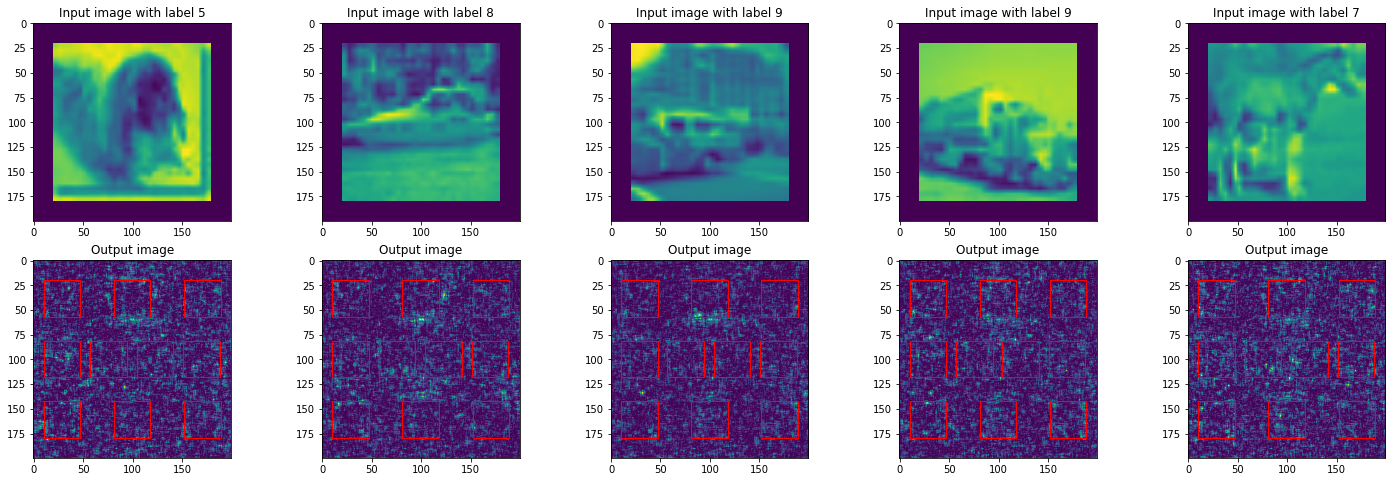

In [65]:
visualize_n_samples(res[-1], val_dataset, n = 5, padding = 0, detector_pos = detector_pos)

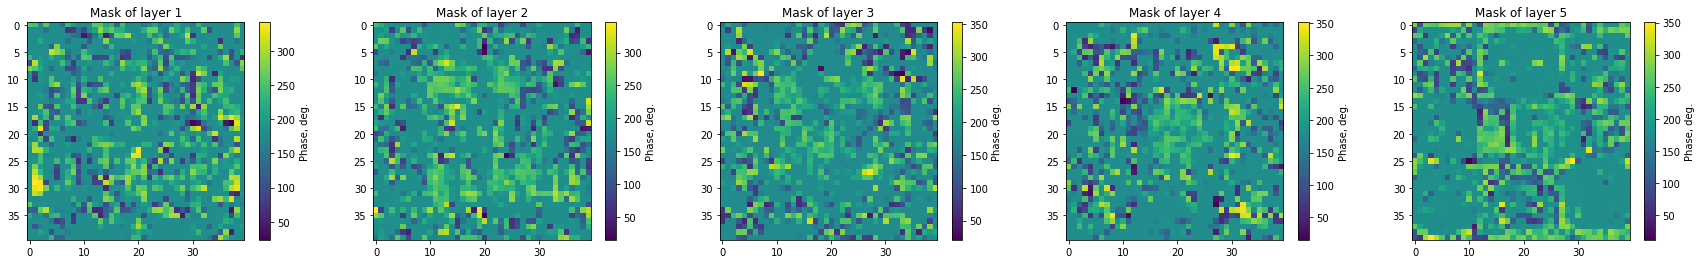

In [67]:
mask_visualization(model)


In [48]:
BATCH_SIZE = 300
IMG_SIZE = 28
N_pixels = 100
PADDING = (N_pixels - IMG_SIZE) // 2

transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Resize((IMG_SIZE,IMG_SIZE)),
                                transforms.Pad(PADDING)])
train_dataset = torchvision.datasets.MNIST("./data", train=True, transform=transform, download=True)
val_dataset = torchvision.datasets.MNIST("./data", train=False, transform=transform, download=True)
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)